# T-Maze Task

In this notebook, we simulate a T-Maze task (also known as the three-arm bandit task) using an active inference (AIF) agent with the `jax-pymdp` library. The `jax-pymdp` package is a newer, enhanced version of the original [`pymdp` package](https://pymdp-rtd.readthedocs.io/en/latest/) that allows for scaling up active inference agents. Built on JAX, `jax-pymdp` allows for faster computation and simulation of active inference models, and the ability to scale models to run multiple agents simultaneously through batching, making it ideal for complex, multi-agent tasks.

The T-Maze task we use in this notebook is adapted from [the sophisticated inference paper](https://discovery.ucl.ac.uk/id/eprint/10124606/). This task represents a classic problem in spatial navigation, learning, and decision-making, where an agent (in this case, a rat) must navigate a T-shaped maze. The agent starts at the centre of the T-maze. Within either the left or right arm, there is either a preferred (i.e., rewarding; cheese) stimulus or an aversive (i.e., punishing; shock) stimulus, with their locations initially unknown to the agent. In the bottom arm, an instructional cue provides information about the location of the rewarding stimulus.

To solve the maze and locate the reward, the agent must decide whether to commit to one of the potentially rewarding arms or first seek information from the cue to identify the more profitable option before taking action. Cue validity, set at 95% in this simulation, represents the probability that the cue correctly indicates the reward's location. An optimal agent should learn to exploit the cue when it is valid and explore the arms when it is not. 

In this notebook, we will create the following simulations: 
1. single agent solving the task with vanilla active inference
2. single agent solving the task with sophisticated inference
3. multiple agents solving the task with vanilla active inference
4. multiple agents solving the task with sophisticated inference

### Initial Setup
To run this notebook, it is recommended to set up and use a virtual environment. You can refer to [this guide](https://packaging.python.org/en/latest/guides/installing-using-pip-and-virtual-environments/) to learn how to set up a virtual environment.

Then, install the current repo, with the `jax-pymdp` package, as a package in editable mode by running the following command in your terminal:
```bash
pip install -e .
```

You also need to install [JAX](https://jax.readthedocs.io/en/latest/installation.html) to run this notebook.

In [10]:
# a way to edit and run code and see the effects in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

# importing necessary libraries
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jax import random as jr
from pymdp.envs import TMaze
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
from pymdp.agent import Agent
from pymdp.envs.tmaze import aif_loop

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The T-Maze Environment

The environment can run multiple instances in parallel by adjusting the `batch_size` parameter.

#### States and Observations

**State Factors:**
1. Location (5 states):
    - 0: centre (start location)
    - 1: left arm
    - 2: right arm
    - 3: cue location (bottom arm)
    - 4: middle of arms (between left and right arm)
2. Reward Location (2 states):
    - 0: reward in left arm 
    - 1: reward in right arm

**Observation Modalities:**
1. Location (5 observations):
    - Matches the location states exactly
2. Outcome (3 observations):
    - 0: no outcome
    - 1: reward (cheese)
    - 2: punishment (shock)
3. Cue (3 observations):
    - 0: no cue
    - 1: left arm cued
    - 2: right arm cued

#### Environment Parameters

**Observation Likelihood Model (A):**
- A[0]: Location observations (5x5x1 tensor)
  - Perfect mapping between true and observed location
- A[1]: Outcome observations (3x5x2 tensor)
  - In correct arm, the `reward_probability` is set at 100% 
  - In incorrect arm, the `punishment_probability` is set at 100%
  - No outcomes in centre or cue locations
- A[2]: Cue observations (3x5x2 tensor)
  - Cue indicates reward location only at cue location, with `cue_validity` set at 95%
  - No cues visible elsewhere

**Transition Model (B):**
- B[0]: Location transitions (5x5x4 tensor)
  - Agent can move between any locations in one step 
- B[1]: Reward location (2x2x1 tensor)
  - Reward location remains fixed throughout trial

**Initial Conditions (D):**
- D[0]: Starting location (5x1 tensor)
  - Agent always begins in centre location
- D[1]: Reward placement (2x1 tensor)
  - Default: Equal chance (50/50) of reward in either arm (reward_condition=None)
  - Optional: Can fix reward to specific arm, by setting `reward_condition` to 0 (for left arm) or 1 (for right arm)  


In [11]:
batch_size = 1 # number of environments to run in parallel
env = TMaze( # initialising the environment
    batch_size=batch_size, 
    reward_probability=1.0,     # 100% chance of reward in correct arm
    punishment_probability=1.0, # 100% chance of punishment in incorrect arm
    cue_validity=1.0,          # 95% valid cues
    reward_condition=1
)

In [12]:
# print(env.params["A"][1].shape)
# print(env.params["A"][1][0][:,:,1])

# print(env.params["A"][2].shape)
print(env.params["A"][2][0][:,:,1])

# print(env.params["B"][0].shape)
# print(env.params["B"][0][0][:,:,4])

print(env.params["D"][0])
print(env.params["D"][1])


[[1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
[[1. 0. 0. 0. 0.]]
[[0. 1.]]


In [13]:
key = jr.PRNGKey(1) # random key for generating random numbers
keys = jr.split(key, 1 + batch_size) # splitting the key into 1 + batch_size keys
key = keys[0] # saving the first key for later use


# Creating the Agent

Riddhi's notes: 
- to try A learning with A[1] - the agent can learn the probability of reward in the correct arm and the probability of punishment in the incorrect arm.
- to try A learning with A[2] - the agent can learn the cue validity.
- apply_batch?? 



In [14]:
A = [jnp.array(a, dtype=jnp.float32) for a in env.params["A"]]
B = [jnp.array(b, dtype=jnp.float32) for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

# create C tensors [location], [reward], [cue] based on A shapes
C = [jnp.zeros((batch_size, a.shape[1]), dtype=jnp.float32) for a in A] 
# set preferences for outcomes only (keeping other preferences at zero)
C[1] = C[1].at[:,1].set(2.0)    # prefer reward - note the [:,1]
C[1] = C[1].at[:,2].set(-3.0)   # avoid punishment - note the [:,2]
# C = [jnp.broadcast_to(c, (batch_size,) + c.shape) for c in C]


# create D tensors [location], [reward] based on B shapes
D = []
# D[0]: location - all zeros except location 0 (centre) because the agent always starts in the centre
D_loc = jnp.zeros((batch_size, B[0].shape[1]), dtype=jnp.float32) 
D_loc = D_loc.at[0,0].set(1.0)  # set centre location to 1.0
D.append(D_loc)

# D[1]: reward location - uniform distribution
D_reward = jnp.ones((batch_size, B[1].shape[1]), dtype=jnp.float32) 
D_reward = D_reward / jnp.sum(D_reward, axis=1, keepdims=True)  # normalise to get uniform distribution
D.append(D_reward)


agent = Agent(
    A, B, C, D, 
    None, None, None, 
    policy_len=6,
    A_dependencies=A_dependencies, 
    B_dependencies=B_dependencies,
    apply_batch=False
)

In [15]:
# print([a.shape for a in A])
# print([b.shape for b in B])
# print([c.shape for c in C])
# print([d.shape for d in D])

# print(agent.A_dependencies)
# print(agent.B_dependencies)

# print(agent.A[0][:,:])
# print(agent.A[1][0][:,:,0])
# print(agent.A[2][0][:,:,1])


# print(agent.B[0][0][:,:,0])
# print(agent.B[1][0][:,:,0])

# print(agent.C[0])

print(agent.D[0])
print(agent.D[1])

[[1. 0. 0. 0. 0.]]
[[0.5 0.5]]


In [16]:
key = jr.PRNGKey(0)
T = 10
_, info, _ = aif_loop(agent, env, num_timesteps=T, rng_key=key)

In [20]:
# print(info["action"][0])
print(info["observation"][2])
# print(info["qs"][1])
# print(info["qpi"][0].shape)

[[[1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]]]


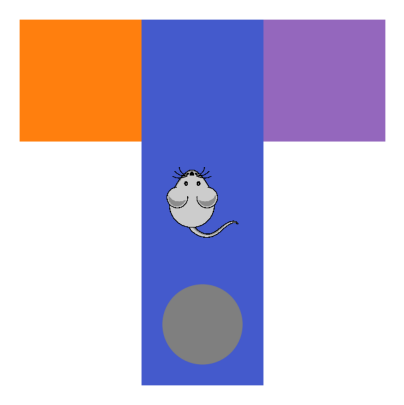

In [18]:
frames = []

# reset environment for agent to be in start location
o, env = env.reset(keys[1:])
frames.append(env.render(mode="rgb_array"))

# append frame for each action 
# actions = [[3,0], [0,0], [4,0], [2,0], [4,0], [1,0]] # manual actions - without agent's generative model
actions = info["action"][0] # from agent's generative model
for action in actions:
    o, env = env.step(keys[1:], jnp.array([action] * batch_size))
    frames.append(env.render(mode="rgb_array"))

# convert to numpy array
frames = np.array(frames)

# creating figure for animation
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')

def animate(frame):
    ax.clear()
    ax.axis('off')
    ax.imshow(frames[frame])
    return ax,

# displaying animation
anim = FuncAnimation(fig, animate, frames=len(frames), interval=1000)
HTML(anim.to_jshtml())

# save as gif
anim.save('tmaze.gif', writer=PillowWriter(fps=1))